In [2]:
import mesa
import mesa.agent
from model import *

# Copy of the model

In [4]:
import mesa
import numpy as np
import mesa
import random

NO_NEIGHBORS_THETA = 0.5

class SchellingAgent(mesa.Agent):
    """
    Schelling segregation agent
    """

    def __init__(self, unique_id, model, agent_type, budget):
        """
        Create a new Schelling agent.

        Args:
           unique_id: Unique identifier for the agent.
           agent_type: Indicator for the agent's type (minority=1, majority=0)
           budget: Budget for the agent
        """
        super().__init__(unique_id, model)
        self.type = agent_type
        self.budget = budget
        self.utility = 0.5

    def step(self):
        """
        Step for agent to move
        """

        available_cells = self.model.find_available_cells(self)
        if len(available_cells) < 0:
            return
        
        # destination = random.choice(available_cells)
        # self.model.grid.move_agent(self, destination)
        
        # TODO - iterate over available cells to find the highest utility, move if higher than current
        
        # TODO - update utility value for current location (only if moved)


class Schelling(mesa.Model):
    """
    Model class for the Schelling segregation model.
    """

    def __init__(
        self,
        property_value_func,
        utility_func,
        price_func,
        height=20,
        width=20,
        homophily=0.5,
        radius=1,
        density=0.8,
        minority_pc=0.2,
        seed=None
    ):
        """
        Create a new Schelling model.

        Args:
            width, height: Size of the space.
            density: Initial chance for a cell to be populated
            minority_pc: Chance for an agent to be in minority class
            homophily: Minimum number of agents of the same class needed to be happy
            radius: Search radius for checking similarity
            seed: Seed for reproducibility
            property_value: Value for the property
        """

        super().__init__(seed=seed)
        self.utility_func = utility_func
        self.price_func = price_func
        self.height = height
        self.width = width
        self.density = density
        self.minority_pc = minority_pc
        self.homophily = homophily
        self.radius = radius
        
        self.schedule = mesa.time.RandomActivation(self)
        self.grid = mesa.space.SingleGrid(width, height, torus=True)

        # Property Value Layer
        self.property_value_layer = property_value_func(name="property_values", width=width, height=height)
        self.grid.add_property_layer(self.property_value_layer)

        # Desirability Layer
        self.desirability_layer = mesa.space.PropertyLayer("desirability", width, height, 1)
        # for _, pos in self.grid.coord_iter():
        #     self.desirability_layer[pos] = 1
        self.grid.add_property_layer(self.desirability_layer)
        
        # Interested Agents Counter Layer
        self.interested_agents_layer = mesa.space.PropertyLayer("interested_agents", width, height, 0)
        # for _, pos in self.grid.coord_iter():
        #     self.interested_agents_layer[pos] = 0
        self.grid.add_property_layer(self.interested_agents_layer)
        
        # self.happy = 0
        self.datacollector = mesa.DataCollector(
            # model_reporters={"happy": "happy"},  # Model-level count of happy agents
        )

        # Set up agents
        for _, pos in self.grid.coord_iter():
            if self.random.random() < self.density:
                agent_type = 1 if self.random.random() < self.minority_pc else 0
                budget = 1000
                agent = SchellingAgent(self.next_id(), self, agent_type, budget)
                self.grid.place_agent(agent, pos)
                self.schedule.add(agent)

        self.datacollector.collect(self)

    def get_theta(self, loc: tuple, type):
        similar = 0
        num_neighbours = 0
        
        for neighbor in self.model.grid.iter_neighbors(
            loc, moore=True, radius=self.model.radius
        ):
            
            num_neighbours += 1
            if neighbor.type == type:
                similar += 1
        
        if num_neighbours == 0:
            return NO_NEIGHBORS_THETA
                
        proportion_similar = similar / num_neighbours
        
        return proportion_similar

    def find_available_cells(self, agent):
        available_cells = []
        for _, pos in self.grid.coord_iter():
            if self.grid.is_cell_empty(pos):
                available_cells.append(pos)        
        return available_cells

    def step(self):
        """
        Run one step of the model.
        """
        # Set the count of agents who like to move somewhere to 0 for all cells
        self.interested_agents_layer.set_cells(0)

        for agent in self.schedule.agents:
            # Iterate over cells and compare utility to current location, add to interested_agents_layer if better
            for _, loc  in self.grid.coord_iter():
                utility = self.utility_func(self, agent.pos, loc)
                
                if utility > agent.utility:
                    self.interested_agents_layer.modify_cell(loc, lambda v: v + 1)
        
        # Set desirability layer to the proportion of interested agents
        num_agents = len(self.schedule.agents)
        self.desirability_layer.set_cells(
            self.interested_agents_layer.data / num_agents
        )
        
        self.schedule.step()
        self.datacollector.collect(self)


# Added modules

In [33]:
def property_value_func(name, width, height) -> mesa.space.PropertyLayer:
    layer = mesa.space.PropertyLayer(name, width, height, 0)
    
    for i in range(height):
        for j in range(width):
            layer[i][j] = abs(np.random.gumbel())

    return layer

In [6]:
def price_func(model: mesa.Model, property_loc: tuple) -> float:
    
    desirability = model.desirability_layer[property_loc]
    property_value = model.property_value_layer[property_loc]
    
    return (0.5 + desirability) * property_value

# Theta function

In [ ]:
def get_theta(x, mu, sigma):
    """
    x: fraction of similar neighbours
    mu: optimal fraction of similar neighbours
    sigma: acceptance range
    """
    theta = np.exp(-((x - mu) ** 2) / (2 * sigma ** 2))
    return theta

In [23]:
def theta(a, b, frac):
    c = a**2
    f = -(b*frac - a)**2 + 2
    f_prime = -4*a**2 #+ c
    return f#/f_prime

def gaussian_function(x, mu, sigma):
    return np.exp(-((x - mu) ** 2) / (2 * sigma ** 2))

In [18]:
def theta2(peak, frac):
    if frac < peak:
        return frac
    else: 
        return -frac + peak

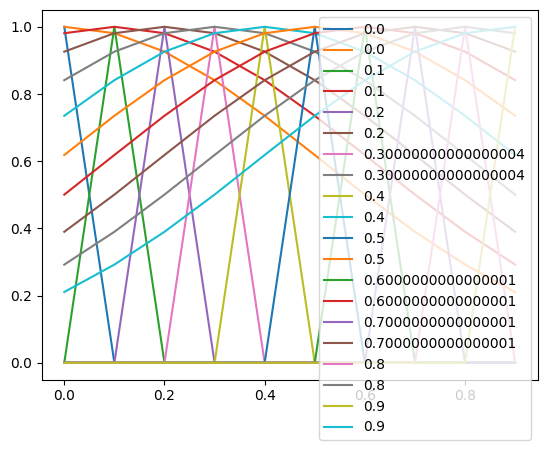

In [31]:
import matplotlib.pyplot as plt
import numpy as np

for a in np.arange(0, 1, 0.1):
    for b in np.arange(0.01, 1, 0.5):

        theta_list = []
        for x in np.arange(0,1,0.1):
            points = gaussian_function(x, a, b)
            theta_list.append(points)
        
        plt.plot(np.arange(0,1,0.1), theta_list, label=a)
plt.legend()

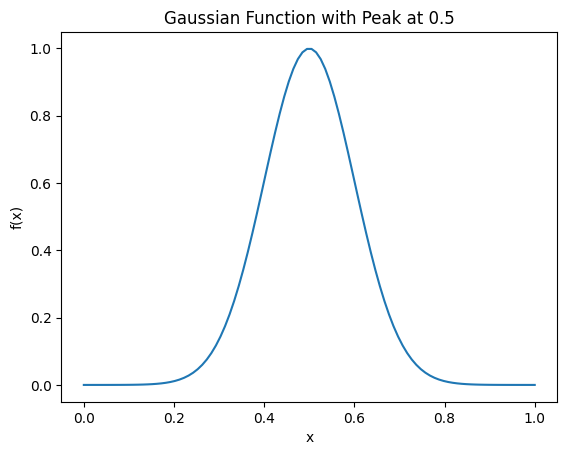

In [33]:
def gaussian_function(x, mu, sigma):
    return np.exp(-((x - mu) ** 2) / (2 * sigma ** 2))

# Example usage:
x_values = np.linspace(0, 1, 100)
mu = 0.5  # Peak in the middle
sigma = 0.1  # Controls the width

y_values = gaussian_function(x_values, mu, sigma)

# You can plot the function to visualize it
import matplotlib.pyplot as plt

plt.plot(x_values, y_values)
plt.xlabel('x')
plt.ylabel('f(x)')
plt.title(f'Gaussian Function with Peak at {mu}')
plt.show()